# Hotel Rating Prediction



<a id = 'import'></a>
### Importing the Dataset and the required libraries

In [1]:
# !pip install vaderSentiment

In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go

from wordcloud import WordCloud,STOPWORDS
stopwords = list(STOPWORDS)

import nltk
# nltk.download('vader_lexicon')
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score 
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer as CVTZ
def set_seed(seed=31415):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

def RMSE(Y,YHAT):
    return np.sqrt(mean_squared_error(Y,YHAT))

plt.rc('figure',figsize=(20,11))

In [3]:
t_data = pd.read_csv('./DataSets/tripadvisor_hotel_reviews.csv')
t_data.head(3)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3


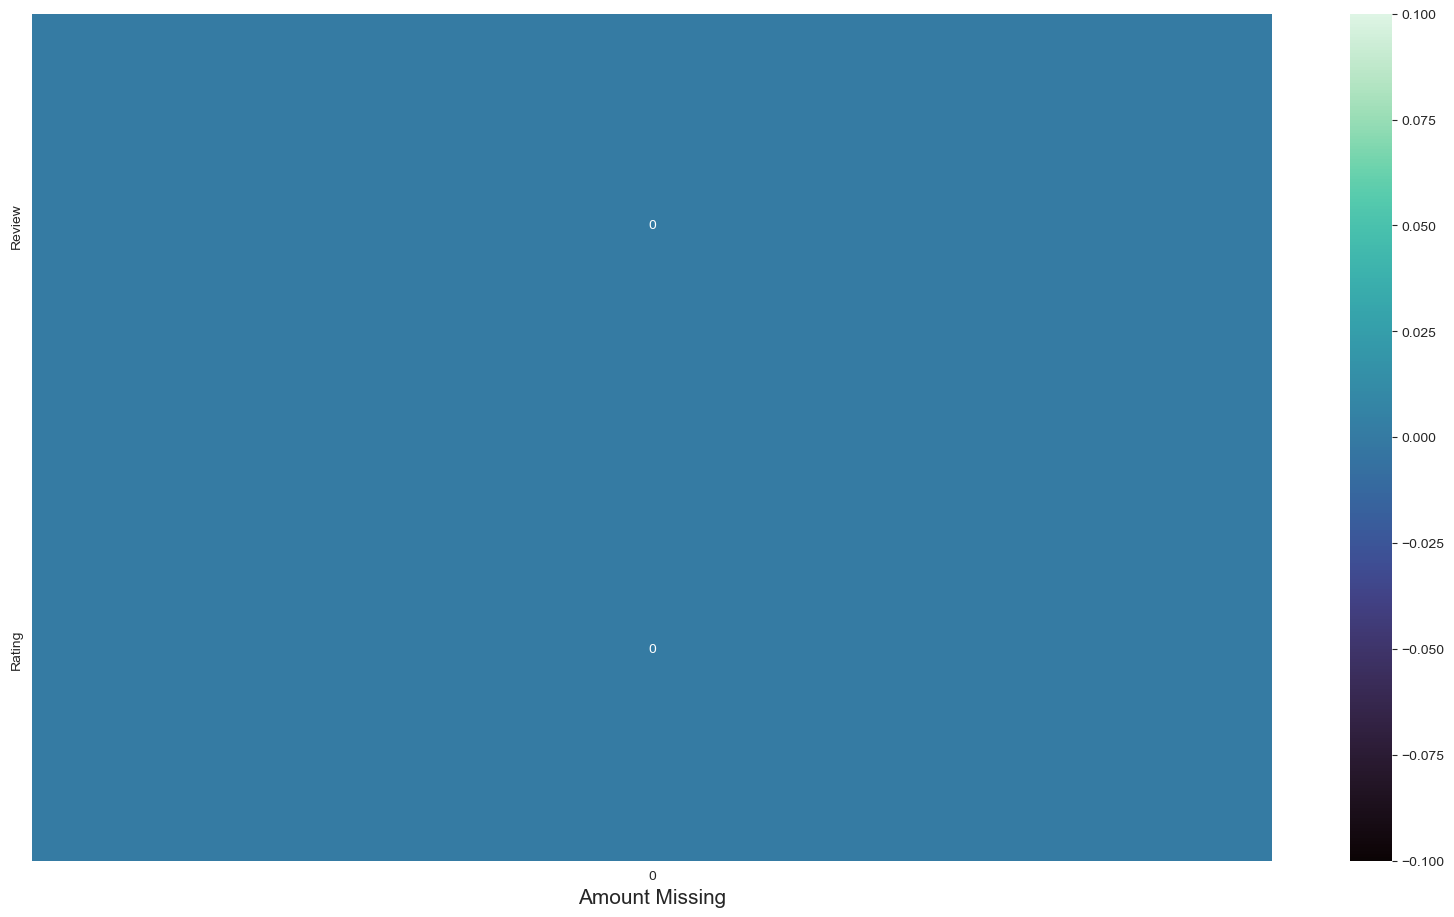

In [4]:
sns.heatmap(t_data.isna().sum().to_frame(),annot=True,cmap='mako')
plt.xlabel('Amount Missing',fontsize=15)
plt.show()

<a id="feature"></a>
### Feature Engineering And Preprocessing
Feature extraction is a process of automatically reducing the dimensionality of these types of observations into a much smaller set that can be modelled.

### Remove Stopwords From Reviews

In [5]:
def remove_stop_words(sir):
    splited = sir.split(' ')
    splited = [word for word in splited if word not in stopwords]
    return ' '.join(splited)

t_data.Review = t_data.Review.apply(remove_stop_words)

In [6]:


def get_char_count(sir):
    return len(sir)
def get_word_count(sir):
    return len(sir.split(' '))
def get_average_word_length(sir):
    aux = 0
    for word in sir.split(' '):
        aux += len(word)
    return aux/len(sir.split(' '))
def get_pos_sentiment(sir):
    sent = sid.polarity_scores(sir)
    return sent['pos']
def get_neg_sentiment(sir):
    sent = sid.polarity_scores(sir)
    return sent['neg']
def get_neu_sentiment(sir):
    sent = sid.polarity_scores(sir)
    return sent['neu']

In [7]:
t_data['Char_Count'] =  t_data.Review.apply(get_char_count)
t_data['Word_Count'] =  t_data.Review.apply(get_word_count)
t_data['Average_Word_Length'] =  t_data.Review.apply(get_average_word_length)
t_data['Positive_Sentiment'] =   t_data.Review.apply(get_pos_sentiment)
t_data['Negative_Sentiment'] = t_data.Review.apply(get_neg_sentiment)
t_data['Neutral_Sentiment'] =t_data.Review.apply(get_neu_sentiment)

NameError: name 'sid' is not defined

<a id="eda"></a>
## Part A :: Exploratory Data Analysis
Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

<a id = 'wordcloud'></a>
### Word Cloud shows most searched words
A word cloud (also known as a tag cloud) is a visual representation of words

In [ ]:
word_list = ''
for word in t_data.Review:
    splited = word.lower()
    word_list +=splited
    
wordcloud = WordCloud(width=800,height=800,background_color='white',stopwords=stopwords,min_font_size=5).generate(word_list)
plt.figure(figsize = (25, 15), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

**Most searched words for the Hotel Rating System**
1. Resort
2. Hotel
3. night
4. day
5. time

<a id = 'positive'></a>
### Postive Sentiment Distribution

In [ ]:
ex.box(t_data,x='Rating',y='Positive_Sentiment',notched=True,title='Rating Positive Sentiment Distributions')

**Insight -1** : We see that the higher the average positive sentiment the higher the rating

<a id = 'negative'></a>
### Negative Sentiment Distribution

In [ ]:
ex.box(t_data,x='Rating',y='Negative_Sentiment',notched=True,title='Rating Negative Sentiment Distributions')

**Insight 2** : And not surprisingly the higher the negative sentiment the lower the rating 

<a id = 'pairplot'></a>
### Visualization using Pair plot

Pair Plots are a really simple (one-line-of-code simple!) way to visualize relationships between each variable. It produces a matrix of relationships between each variable in your data for an instant examination of our data. It can also be a great jumping off point for determining types of regression analysis to use.

In [ ]:
sns.pairplot(t_data)

<a id = 'jointplot'></a>
### Visualization using Joint Grid Plot

Seaborn's jointplot displays a relationship between 2 variables (bivariate) as well as 1D profiles (univariate) in the margins. This plot is a convenience class that wraps JointGrid. 'hex' bins the data into hexagons with histograms in the margins

In [ ]:
sns.jointplot(x=t_data['Average_Word_Length'],y=t_data['Positive_Sentiment'],height=15,kind='kde',levels=20)

In [ ]:
print('Average_Word_Length Skew: ',t_data['Average_Word_Length'].skew(),"  Average_Word_Length Kurtosis",t_data['Average_Word_Length'].kurt())

In [ ]:
print('Average_Word_Length Mean: ',t_data['Average_Word_Length'].mean(),"  Average_Word_Length Median",t_data['Average_Word_Length'].median(),' Average_Word_Length Mode : ',t_data['Average_Word_Length'].mode()[0])

### The Average_Word_Length Is Approximately Normally Distributed

In [ ]:
data_info = t_data.describe()
data_info.loc['skew'] = t_data.skew()
data_info.loc['kurt'] = t_data.kurt()
data_info

<a id = 'scatter'></a>
### 3 dimensional Scatter Plot
3D scatter plots are used to plot data points on three axes in the attempt to show the relationship between three variables. Each row in the data table is represented by a marker whose position depends on its values in the columns set on the X, Y, and Z axes.

In [ ]:
tout_l = t_data.copy()
tout_l['OLL'] = 'Normal'
tout_l.loc[tout_l[tout_l['Word_Count']>1000].index,'OLL']= 'Outlier'
tout_l.loc[tout_l[tout_l['Neutral_Sentiment']<0.25].index,'OLL']= 'Outlier'
tout_l.loc[tout_l[tout_l['Neutral_Sentiment']>0.98].index,'OLL']= 'Outlier'

ex.scatter_3d(tout_l,x='Rating',y='Neutral_Sentiment',z='Word_Count',color='OLL')

<a id = 'outlier'></a>
### Outlier Removal
An outlier is an object that deviates significantly from the rest of the objects. They can be caused by measurement or execution error. The analysis of outlier data is referred to as outlier analysis or outlier mining.

In [ ]:
t_data = t_data[t_data['Neutral_Sentiment']>0.25]
t_data = t_data[t_data['Neutral_Sentiment']<0.98]
t_data = t_data[t_data['Word_Count']<1000]

In [ ]:
cors = t_data.corr('pearson')
plt.figure(figsize=(20,13))
sns.heatmap(cors,annot=True,cmap='mako')

In [ ]:
t_data.head(3)

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(t_data[['Positive_Sentiment','Negative_Sentiment','Average_Word_Length']],t_data['Rating'])

# Prediction Models


### Gausian Naive Bayes Classifier Algorithm

In [ ]:
GN = GaussianNB()
GN.fit(train_x,train_y)
GN_predictions= GN.predict(test_x)

cfm = confusion_matrix(GN_predictions,test_y)

plt.figure(figsize=(8,8))
plt.title('Naive Bayes Confusion Matrix',fontsize=20)
sns.heatmap(cfm,annot=True,cmap='mako',fmt='d',xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])


acc_GNB = accuracy_score (GN_predictions,test_y)
print('GNB accuracy: ', acc_GNB )

<a id = 'dtc'></a>
### Decision Tree Classifier
Decision Tree is a Supervised learning technique that can be used for both classification and Regression problems, but mostly it is preferred for solving Classification problems. It is a tree-structured classifier, where internal nodes represent the features of a dataset, branches represent the decision rules and each leaf node represents the outcome.

In [ ]:
DT = DecisionTreeClassifier()
DT.fit(train_x,train_y)
DT_predictions= DT.predict(test_x)
cfm = confusion_matrix(DT_predictions,test_y)

plt.figure(figsize=(8,8))
plt.title('Decision Tree Confusion Matrix',fontsize=20)
sns.heatmap(cfm,annot=True,cmap='mako',fmt='d',xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])

acc_DT = accuracy_score (DT_predictions,test_y)
print('DT accuracy: ', acc_DT)



<a id = 'rfc'></a>
### Random Forest Classifier
Random Forest is a popular machine learning algorithm that belongs to the supervised learning technique. It can be used for both Classification and Regression problems in ML. It is based on the concept of ensemble learning, which is a process of combining multiple classifiers to solve a complex problem and to improve the performance of the model.

In [ ]:
RF  = RandomForestClassifier()
RF.fit(train_x,train_y)
RF_predictions= RF.predict(test_x)
cfm = confusion_matrix(RF_predictions,test_y)

plt.figure(figsize=(8,8))
plt.title('Random Forest ',fontsize=20)
sns.heatmap(cfm,annot=True,cmap='mako',fmt='d',xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])

acc_RF = accuracy_score (RF_predictions,test_y)
print('accuracy: ', acc_RF )



<a id = 'log'></a>
### Logistic Regression
 Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).

In [ ]:
from sklearn.linear_model import LogisticRegression
Logreg= LogisticRegression()
Logreg.fit(train_x,train_y)
Logreg_predictions= Logreg.predict(test_x)
cfm = confusion_matrix(Log_predictions,test_y)

plt.figure(figsize=(8,8))
plt.title('Logistic Regression',fontsize=20)
sns.heatmap(cfm,annot=True,cmap='mako',fmt='d',xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])

acc_Logreg =  accuracy_score (Logreg_predictions,test_y)
print('LogReg accuracy: ', acc_Logreg )



### SVM Classification

In [ ]:
from sklearn.svm import SVC

svc = SVC(random_state=1) 
svc.fit(train_x,train_y)
svc_predictions= svc.predict(test_x)
cfm = confusion_matrix(svc_predictions,test_y)

plt.figure(figsize=(8,8))
plt.title('SVM Confusion Matrix',fontsize=20)
sns.heatmap(cfm,annot=True,cmap='mako',fmt='d',xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])

acc_svc = accuracy_score (svc_predictions,test_y)
print('SVC accuracy: ', acc_svc )



### K-Nearest Neighbour Algorithm

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(train_x,train_y)
knn_predictions= knn.predict(test_x)
cfm = confusion_matrix(knn_predictions,test_y)

plt.figure(figsize=(8,8))
plt.title('KNN Confusion Matrix',fontsize=20)
sns.heatmap(cfm,annot=True,cmap='mako',fmt='d',xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])

acc_knn = accuracy_score (knn_predictions,test_y)
print('knn accuracy: ', acc_knn)

acc_GNB, acc_DT, acc_RF, acc_Logreg, acc_svc, acc_knn

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


### Gradient Boosting Algorithm


In [ ]:
gb = GradientBoostingClassifier(n_estimators= 1000, max_leaf_nodes= 4, max_depth=None,random_state= 2,min_samples_split= 5)
gb.fit(train_x,train_y)
gb_predictions= gb.predict(test_x)
cfm = confusion_matrix(gb_predictions,test_y)

plt.figure(figsize=(8,8))
plt.title('Gradient Boosting Confusion Matrix',fontsize=20)
sns.heatmap(cfm,annot=True,cmap='mako',fmt='d',xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])

acc_gb =  accuracy_score (gb_predictions,test_y)
print('Gradient Boosting accuracy: ', acc_gb)



<a id = 'ada'></a>
### AdaBoost Algorithm
AdaBoost, short for Adaptive Boosting, is a statistical classification meta-algorithm formulated by Yoav Freund and Robert Schapire, who won the 2003 Gödel Prize for their work. It can be used in conjunction with many other types of learning algorithms to improve performance.

In [ ]:
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(train_x,train_y)
ada_predictions= ada.predict(test_x)
cfm = confusion_matrix(ada_predictions,test_y)

plt.figure(figsize=(8,8))
plt.title('Adaboost Confusion Matrix',fontsize=20)
sns.heatmap(cfm,annot=True,cmap='mako',fmt='d',xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])

acc_ada = accuracy_score (ada_predictions,test_y)
print('accuracy: ', acc_ada)



### Artificial Neural Networks Algorithm

In [ ]:
ann  = MLPClassifier(alpha=1, max_iter=1000)
ann.fit(train_x,train_y)
ann_predictions= ann.predict(test_x)
cfm = confusion_matrix(ann_predictions,test_y)

plt.figure(figsize=(8,8))
plt.title('Artificial Neural Networks Confusion Matrix',fontsize=20)
sns.heatmap(cfm,annot=True,cmap='mako',fmt='d',xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])

acc_ann = accuracy_score (ann_predictions,test_y)
print('Artificial Neural Networks accuracy: ', acc_ann)



<a id = 'truncated-svd'></a>
### Truncated SVD
The truncated singular value decomposition (SVD) is considered as a method for regularization of ill-posed linear least squares problems. In particular, the truncated SVD solution is compared with the usual regularized solution. Necessary conditions are defined in which the two methods will yield similar results.

**So far we see that using sentiments and basic text features we have no segnificant results, we will know try our second approch in which we will vectorize our text data and use our naive bayes model again to try and predict a reduced version of the vectorized text.**

In [ ]:
tf_model = CVTZ()
N_COMPONENTS = 900

svd_model = TruncatedSVD(n_components = N_COMPONENTS)
desc_matrix = tf_model.fit_transform(t_data.Review)
trunc_matrix = svd_model.fit_transform(desc_matrix)

evr = svd_model.explained_variance_ratio_
evr_cs = np.cumsum(evr)
tr1 = go.Scatter(x=np.arange(0,len(evr_cs)),y=evr_cs,name='Explained Variance Cumulative')
tr2 = go.Scatter(x=np.arange(0,len(evr_cs)),y=evr,name='Explained Variance')

fig = go.Figure(data=[tr1,tr2],layout=dict(title='Explained Variance Ratio Using {} Components'.format(N_COMPONENTS),
                                          xaxis_title='Number Of Components',yaxis_title='Explained Variance Ratio'))

fig.show()


In [ ]:
dec_df = pd.DataFrame(trunc_matrix,columns=['PC_{}'.format(i) for i in range(0,900)])
dec_df.head(3)

In [ ]:
models = pd.DataFrame({
    'model': ['Gaussian Naive Bayes','Decision Tree', 'Random Forest','Logistic Regression', 'Linear SVC', 
              'KNN', 'GBC', 'AdaBoost', 'Art Neural Network'],
    'score': [acc_GNB, acc_DT, acc_RF, acc_Logreg, acc_svc, acc_knn, acc_gb, acc_ada, acc_ann]})

sns.barplot(x='score', y='model', data=models)

models.sort_values(by='score', ascending=False)